<a href="https://colab.research.google.com/github/nareshpatel1015/ml-mnist-classification-pipeline/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import mnist 784 data from open ml and by using as_frame=False, it is in array datatype and not in dataframe, version=1 to fetch the latest dataset
from sklearn.datasets import fetch_openml

mnist_dataset = fetch_openml('mnist_784', version=1, as_frame=False)

In [5]:
#analyse keys in the dataset
mnist_dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
#gettign important columns from dataset
X,y = mnist_dataset['data'], mnist_dataset['target']

In [7]:
#see the array types and number of rows in each column
X.shape

(70000, 784)

In [8]:
#see the array types and number of rows in each column
y.shape

(70000,)

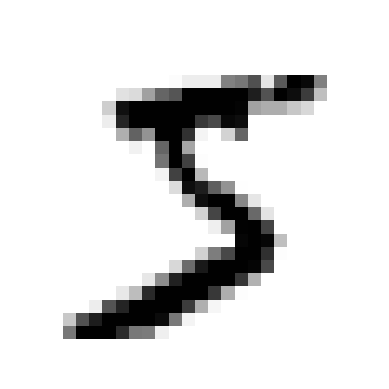

In [9]:
#seeing the image of first row

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
#converting a 1D array to a 2D array, we have converted to 28 cross 28 2D array
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [10]:
#let's see the label of some digit image
y[0]

'5'

In [11]:
#convert string to integer of lables
import numpy as np

y = y.astype(np.uint8)

In [12]:
#Split the data in to test and train
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test_data_by_stratified(X,y,test_size):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
  for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  return X_train, X_test, y_train, y_test

In [13]:
#spliting data for training and testing using StrartifiedShuffleSplit
X_train, X_test, y_train, y_test = split_train_test_data_by_stratified(X,y, 0.1)

In [14]:
#implementing the Stochastic Gredient Decent (SGD) classifier
# doing binary classification of digit 5
from sklearn.linear_model import SGDClassifier

y_train_5 = y_train == 5

sgd_clff = SGDClassifier(random_state = 42)
sgd_clff.fit(X_train, y_train_5)

#predicting the some digit on trainned SGD model
sgd_clff.predict([some_digit])

array([ True])

In [15]:
# implementing Cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clonned_sgd_clff = clone(sgd_clff)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]
  clonned_sgd_clff.fit(X_train_folds, y_train_folds)
  y_pred = clonned_sgd_clff.predict(X_test_folds)
  n_correct = sum(y_pred == y_test_folds)
  print(n_correct/len(y_pred))



0.9680952380952381
0.932
0.9582857142857143


In [16]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clff, X_train, y_train_5, cv=3, scoring="accuracy")
print(scores)

[0.96809524 0.932      0.95828571]


In [17]:
#cross_val_predict() performs K-fold cross-validation,
#it returns the predictions made on each test fold.
#This means that you get a clean prediction for each instance in the training set
#clean:(“clean” meaning that the prediction is made by a model that never saw the data during training.

from sklearn.model_selection import cross_val_predict

y_cross_predict_5 = cross_val_predict(sgd_clff, X_train, y_train_5, cv=3)

In [18]:
#Confusion metrix

#([[True Negative False Positive]
#[False Negative True Positive]])
#True Negative : Truely predicted, not 5's
#False Positive : Wrongly predicted, not 5's
#False Negative : wrongly predicted actual 5
#True Postitive : truly predicted actual 5
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_cross_predict_5)


array([[55250,  2068],
       [  906,  4776]])

In [19]:
# calculating Precision and Recall
# Precision: how much you trust on model when it predicts 5
# Recall: how many actual 5, the model was able to predict.

from sklearn.metrics import precision_score, recall_score

precise_score = precision_score(y_train_5, y_cross_predict_5)
recall_score = recall_score(y_train_5, y_cross_predict_5)

print(precise_score)
print(recall_score)

0.6978375219170077
0.8405491024287223


In [20]:
#cacluating the f1 score:
#F1 score = the harmonic mean of precision and recall.
# this keeps balance between precision and recall
from sklearn.metrics import f1_score

f1_score_val = f1_score(y_train_5, y_cross_predict_5)
print(f1_score_val)

0.7625738463994891


In [21]:
#Decision score -> how confident the model is about its prediction, before it turns that confidence into a final “Yes/No” or “Positive/Negative” label

y_decision_score = sgd_clff.decision_function([some_digit])
print(y_decision_score)

[5985.04841442]


In [22]:
#define threshold and use it in making decision
threshold = 0
y_some_digit_pred_confident = (y_decision_score > threshold)
print(y_some_digit_pred_confident)

[ True]


In [23]:
#Increase the threshold and see what happends
# we will observe that increasing the threshold will increasing the recall and decrease the precision
threshold = 7000
y_some_digit_pred_confident = (y_decision_score > threshold)
print(y_some_digit_pred_confident)

[False]


In [24]:
#Ways to decide threshold
# 1. use cross_val_predict first with decision_function method
#calculating cross value prediction scores for ROC curve

y_scores = cross_val_predict(sgd_clff, X_train, y_train_5, cv=3, method='decision_function')

In [25]:
#With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [26]:
#created function to plot precision recall vs threshold
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, highlight_threshold=None):
  plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
  plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")

  # Highlight a specific threshold (optional)
  if highlight_threshold is not None:
      # Find closest threshold index
      idx = (abs(thresholds - highlight_threshold)).argmin()
      plt.plot([thresholds[idx], thresholds[idx]], [0, 1], "r:", label=f"Threshold = {thresholds[idx]:.2f}")
  plt.xlabel("Decision Threshold")
  plt.ylabel("Score")
  plt.title("Precision and Recall vs Decision Threshold")
  plt.legend(loc="center right")
  plt.ylim([0, 1])
  plt.grid(True)
  plt.show()

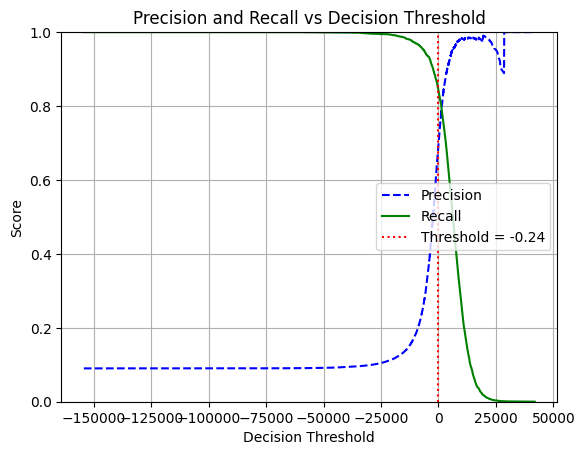

In [27]:
#plotting precision,recalls vs thresholds
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, 0.0)

In [28]:
#plotting precisions vs recalls

def plot_precision_vs_recall(precisions, recalls):
  plt.figure(figsize=(6,5))
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision Vs Recall")
  plt.grid(True)
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.show()

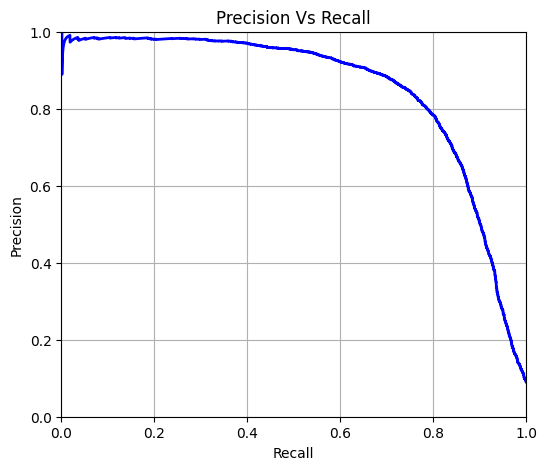

In [29]:
plot_precision_vs_recall(precisions, recalls)

In [30]:
#finding the threshold to get 95 percent precision, and what will be recall for this precision?

threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]
print(threshold_95_precision)

5968.822807703441


In [31]:
#finding the precision score and recall score
# y_train_pred_95 = (y_scores > threshold_95_precision)
# precision_score(y_train_5, y_train_pred_95)
# recall_score(y_train_5, y_train_pred_95)



In [32]:
#find fpr, tpr, thresholds
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [33]:
#plotting roc curve tpr vs fpr

def plot_roc_curve(tpr, fpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label = label)
  plt.plot([0,1], [0,1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.grid(True)
  plt.title("TPR vs FPR")
  plt.xlim([0,1])
  plt.ylim([0,1])

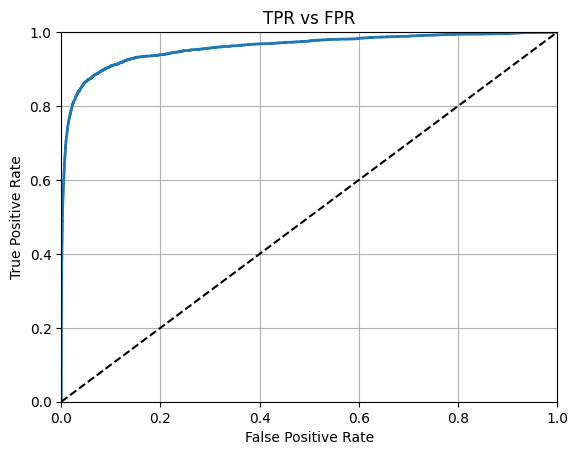

In [34]:
plot_roc_curve(tpr, fpr)
plt.show()

In [35]:
#One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:
#find AUC (area under curve)
from sklearn.metrics import roc_auc_score

auc_score_5 = roc_auc_score(y_train_5, y_scores)
print(auc_score_5)

0.9590098990030965


In [36]:
#now using random forest classifier for the comparision with SGD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

random_forest_clff = RandomForestClassifier(random_state=42)

#it has not decision_function, so will use predict_proba

random_predict_proba  = cross_val_predict(random_forest_clff, X_train, y_train_5, cv=3, method = 'predict_proba')

#This will be a 2D array of shape (n_samples, 2) because there are two classes:
#Column 0 → probability of the negative class (not a 5)
#Column 1 → probability of the positive class (is a 5)

y_scores_forest = random_predict_proba[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

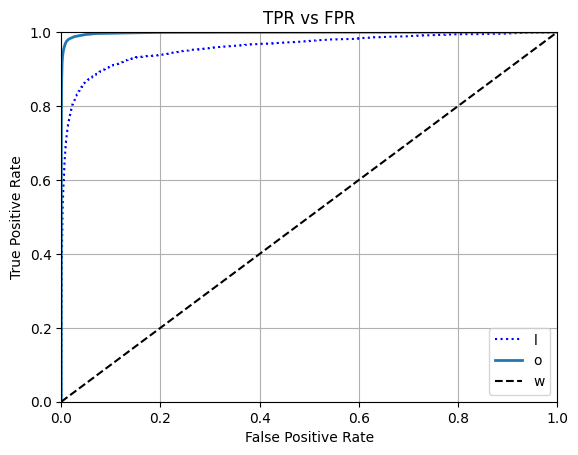

In [37]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(tpr_forest, fpr_forest, "Random Forest")
plt.legend("lower right")
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
#finding auc score
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983496774308603)

In [39]:
#MULTICLASS Classification
# svc decides by its own either OvsO or OvsR
#OvsO -> one vs one strategy ->  one classifier per pair of class | N(N-1)/2 -> you train a separate binary classifier for every possible pair of classes
#OvsR -> one vs rest strategy -> one classifier per class

from sklearn.svm import SVC

svm_clff = SVC()
svm_clff.fit(X_train, y_train)

SVC()

In [40]:
#testing the model with an input of some digit
svm_clff.predict([some_digit])

array([5], dtype=uint8)

In [41]:
#finding decision_scores using decision_function of predictions
some_digit_decision_scores = svm_clff.decision_function([some_digit])
some_digit_decision_scores

array([[ 1.7205999 ,  2.73422063,  7.2568514 ,  8.30748412, -0.31177703,
         9.31334634,  1.71228699,  2.78890027,  6.19124602,  4.86684057]])

In [42]:
svm_clff.classes_
np.argmax(some_digit_decision_scores)
svm_clff.classes_[5]

np.uint8(5)

In [43]:
#forcefully implementing OneVsRest Classifier in svm
#it is time consuming
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
ovr_clf.predict([some_digit])

In [44]:
#Train using SGD (Stochastic Greient Descent)

sgd_clff.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [45]:
sgd_clff.predict([some_digit])
sgd_clff.decision_function([some_digit])

cross_val_score(sgd_clff,X_train, y_train, cv=3, scoring="accuracy")

array([0.88347619, 0.88285714, 0.89038095])

In [46]:
#doing standardscaler for better accuracy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clff, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#confusion matrix to visualize or analyse the model

y_train_pred = cross_val_predict(sgd_clff, X_train_scaled, y_train, cv=3)
conf_mx  =confusion_matrix(y_train, y_train_pred)
conf_mx

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clff = KNeighborsClassifier()
knn_clff.fit(X_train, y_train_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clff.predict([some_digit])

In [48]:
#analysing how good the model is by finding the f1_score using "macro" -> Treats all classes equally even though any single class has more samples

y_train_knn_predc = cross_val_predict(knn_clff, X_train, y_train_multilabel, cv=3)
f1_score(y_train_multilabel, y_train_knn_predc, average="macro")

0.9775414450419707

In [49]:
y_train_pred = cross_val_predict(sgd_clff, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


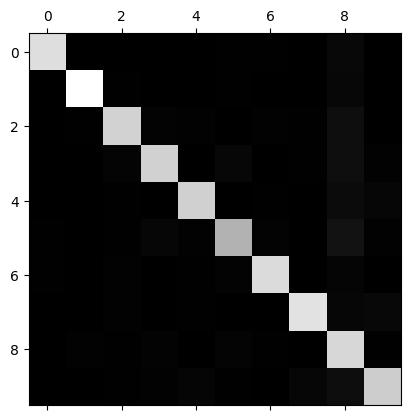

In [50]:
#plotting confusion matrix: row represents actual value and column represent predicted values
#light signifies to the actual predictions are good, if there is a high value(darker) can have either reasons
 #1. fewer images of that darker class
 #2. the classifier has not performed well on that class
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
#To fix the influence of a single class we normalize each value in confusion matrix betwee 0 to 1, by dividing the sum of each row
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

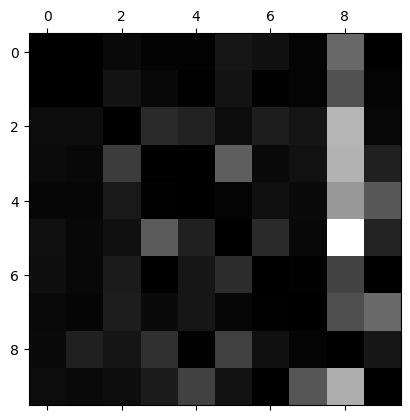

In [52]:
# Fill the diagonal with zeros to keep only the errors, and plot the result:

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()